# Conformal Prediction in Finance: Full Workflow

This notebook fetches real stock data, engineers features, trains models, generates split- and cross-conformal intervals, and backtests interval performance, complete with explanations.

## 1. Setup & Imports

We start by importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from mapie.regression import MapieRegressor
import matplotlib.pyplot as plt

## 2. Download & Prepare Data

- Pull daily prices for AAPL (2015–2025)
- Use Adjusted Close if available, else fallback to Close
- Compute daily log-returns for stationarity

In [3]:
import yfinance as yf
import pandas as pd

# Parameters
ticker     = 'AAPL'
start_date = '2015-01-01'
end_date   = '2025-01-01'

# Download
data = yf.download(ticker, start=start_date, end=end_date)

# Pick available price column
if 'Adj Close' in data.columns:
    prices = data['Adj Close']
elif 'Close' in data.columns:
    prices = data['Close']
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' found in downloaded data.")

# Ensure we have a Series
if isinstance(prices, pd.DataFrame):
    prices_series = prices.iloc[:, 0]
else:
    prices_series = prices

# Build DataFrame with a consistent column name
df = pd.DataFrame(prices_series.values, index=prices_series.index, columns=['price'])

# Compute returns
df['return'] = df['price'].pct_change()
df.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


## 3. Feature Engineering

- Lagged returns to capture autocorrelation
- Rolling mean & volatility as simple technical indicators

In [4]:
df['lag1']        = df['return'].shift(1)
df['lag2']        = df['return'].shift(2)
df['roll_mean_5'] = df['return'].rolling(5).mean().shift(1)
df['roll_std_5']  = df['return'].rolling(5).std().shift(1)
df.dropna(inplace=True)

# Prepare features and target
features = ['lag1', 'lag2', 'roll_mean_5', 'roll_std_5']
X_all    = df[features].values
y_all    = df['return'].values


## 4. Chronological Train / Calibration / Test Split

- Train on earliest data
- Hold out 300 samples for calibration (split-conformal)
- Reserve last 200 points for out-of-sample test

In [5]:
test_size  = 200
calib_size = 300

X_train = X_all[:-(calib_size + test_size)]
y_train = y_all[:-(calib_size + test_size)]

X_calib = X_all[-(calib_size + test_size):-test_size]
y_calib = y_all[-(calib_size + test_size):-test_size]

X_test  = X_all[-test_size:]
y_test  = y_all[-test_size:]


## 5. Split‑Conformal Prediction (MAPIE “base”)

- Obtain a fixed quantile of calibration residuals
- Construct intervals [\hat y \pm q] for the test set

In [6]:
alpha      = 0.1   # 90% prediction intervals
rf         = RandomForestRegressor(n_estimators=100, random_state=42)
mapie_base = MapieRegressor(estimator=rf, method='base')

# Fit on train + calibration
mapie_base.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)

# Predict on test
_, pis_base = mapie_base.predict(X_test, alpha=alpha)
lower_base, upper_base = pis_base[:,0,0], pis_base[:,1,0]


## 6. Cross‑Conformal (Jackknife+) Prediction

- Retrain in 5 folds, aggregate residuals per test point
- Intervals adapt to local uncertainty

In [7]:
mapie_plus = MapieRegressor(estimator=rf, method='plus', cv=5)
mapie_plus.fit(X_train, y_train)

_, pis_plus = mapie_plus.predict(X_test, alpha=alpha)
lower_plus, upper_plus = pis_plus[:,0,0], pis_plus[:,1,0]


## 7. Rolling‑Window Backtests

Compute 50-day rolling:
- **Coverage**: fraction of test points inside the interval
- **Width**: average interval width

In [8]:
window = 50

# Split-conformal metrics
cov_base = ((y_test >= lower_base) & (y_test <= upper_base)).astype(int)
wid_base = upper_base - lower_base
rolling_cov_base = pd.Series(cov_base).rolling(window).mean()
rolling_wid_base = pd.Series(wid_base).rolling(window).mean()

# Jackknife+ metrics
cov_plus = ((y_test >= lower_plus) & (y_test <= upper_plus)).astype(int)
wid_plus = upper_plus - lower_plus
rolling_cov_plus = pd.Series(cov_plus).rolling(window).mean()
rolling_wid_plus = pd.Series(wid_plus).rolling(window).mean()


## 8. Plot Results

Compare split‑conformal vs. jackknife+ in rolling coverage and width

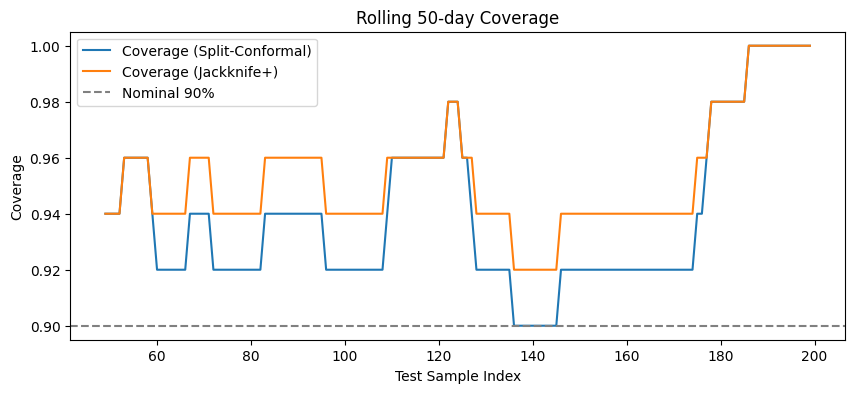

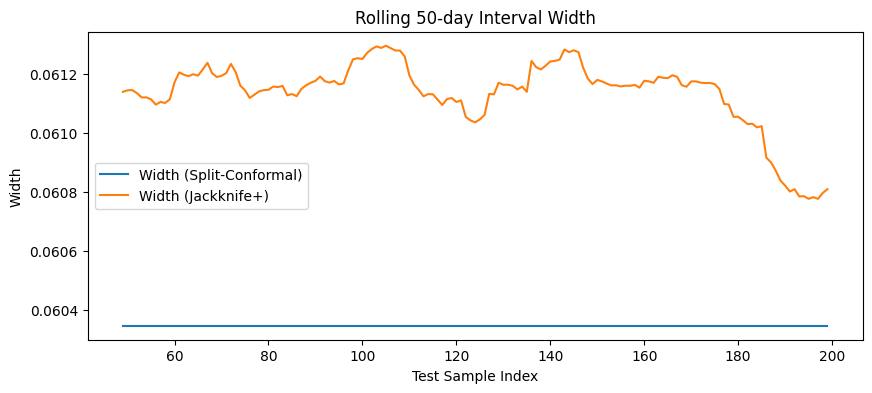

In [9]:
# Coverage comparison
plt.figure(figsize=(10,4))
plt.plot(rolling_cov_base, label='Coverage (Split‑Conformal)')
plt.plot(rolling_cov_plus, label='Coverage (Jackknife+)')
plt.axhline(1-alpha, linestyle='--', color='gray', label='Nominal 90%')
plt.title('Rolling 50-day Coverage')
plt.xlabel('Test Sample Index')
plt.ylabel('Coverage')
plt.legend()
plt.show()

# Width comparison
plt.figure(figsize=(10,4))
plt.plot(rolling_wid_base, label='Width (Split‑Conformal)')
plt.plot(rolling_wid_plus, label='Width (Jackknife+)')
plt.title('Rolling 50-day Interval Width')
plt.xlabel('Test Sample Index')
plt.ylabel('Width')
plt.legend()
plt.show()